# 第11章 : 回帰モデルとその評価。クロスバリデーション、グリッドサーチ

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='talk', style='darkgrid', font='MS GOTHIC')

## 探索的データ分析(EDA)

In [3]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

In [5]:
X, y = load_diabetes(return_X_y=True)

In [6]:
X[:5]

array([[ 0.03807591,  0.05068012,  0.06169621,  0.02187239, -0.0442235 ,
        -0.03482076, -0.04340085, -0.00259226,  0.01990749, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, -0.02632753, -0.00844872,
        -0.01916334,  0.07441156, -0.03949338, -0.06833155, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, -0.00567042, -0.04559945,
        -0.03419447, -0.03235593, -0.00259226,  0.00286131, -0.02593034],
       [-0.08906294, -0.04464164, -0.01159501, -0.03665608,  0.01219057,
         0.02499059, -0.03603757,  0.03430886,  0.02268774, -0.00936191],
       [ 0.00538306, -0.04464164, -0.03638469,  0.02187239,  0.00393485,
         0.01559614,  0.00814208, -0.00259226, -0.03198764, -0.04664087]])

In [9]:
y[:5]

array([151.,  75., 141., 206., 135.])

In [10]:
X.shape, y.shape

((442, 10), (442,))

In [12]:
Xy = np.concatenate([X, y.reshape(-1, 1)], axis=1)

In [13]:
Xy.shape

(442, 11)

In [14]:
df = pd.DataFrame(Xy, columns=diabetes['feature_names'] + ['target'])

In [15]:
df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


In [16]:
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


In [18]:
df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


In [19]:
df['sex'].unique()

array([ 0.05068012, -0.04464164])

In [27]:
def plot_data(feature):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), tight_layout=True)
    sns.histplot(data=df, x=feature, hue='sex', multiple='dodge', ax=axes[0])
    axes[0].legend([], frameon=False)
    sns.boxplot(data=df, x='sex', y=feature, width=0.5, ax=axes[1])
    axes[1].set_xticklabels([])
    sns.scatterplot(data=df, x=feature, y=y, hue='sex', alpha=.7, ax=axes[2])
    axes[2].legend([], frameon=False)
    plt.suptitle(feature)
    plt.show()

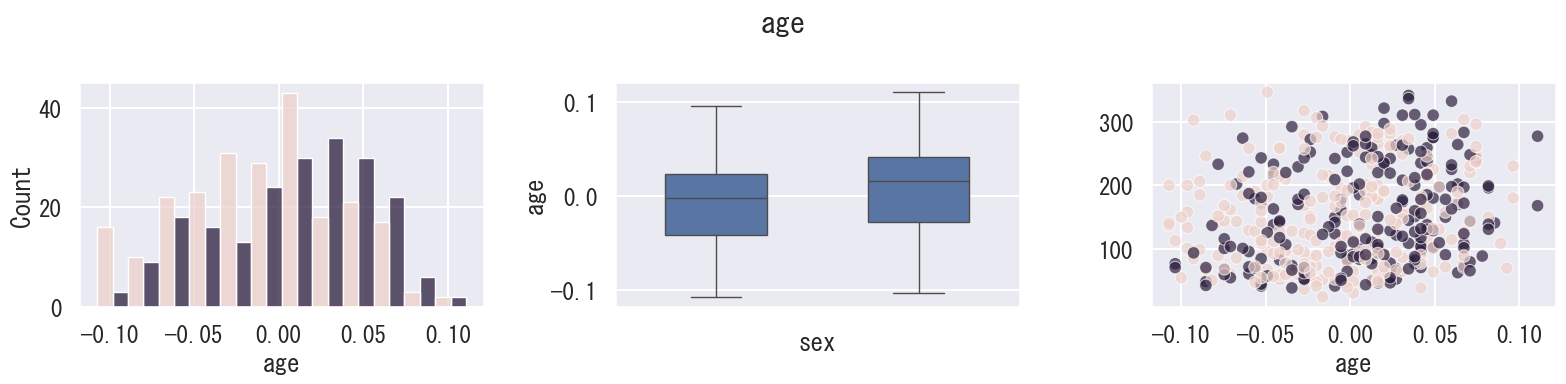

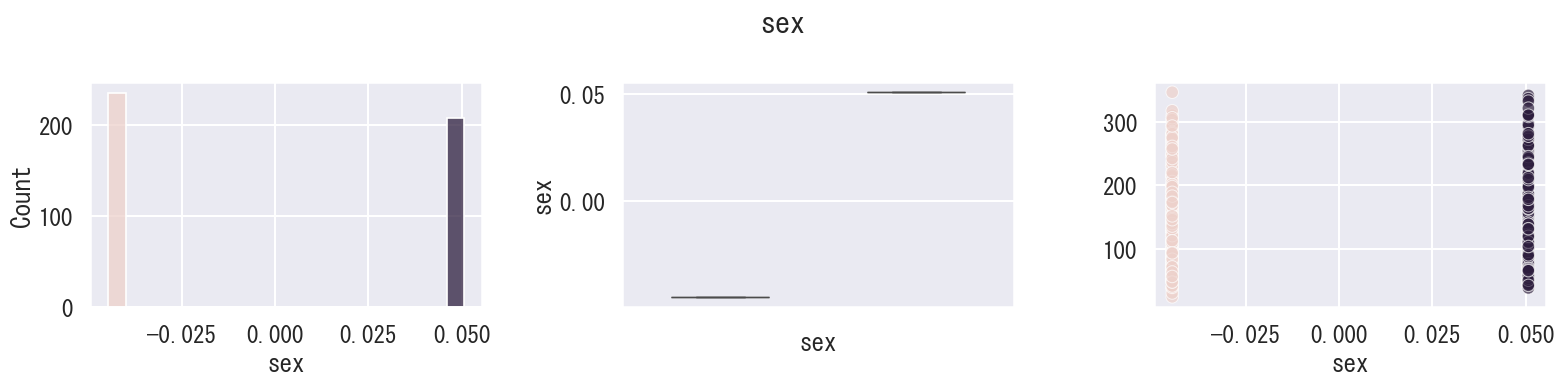

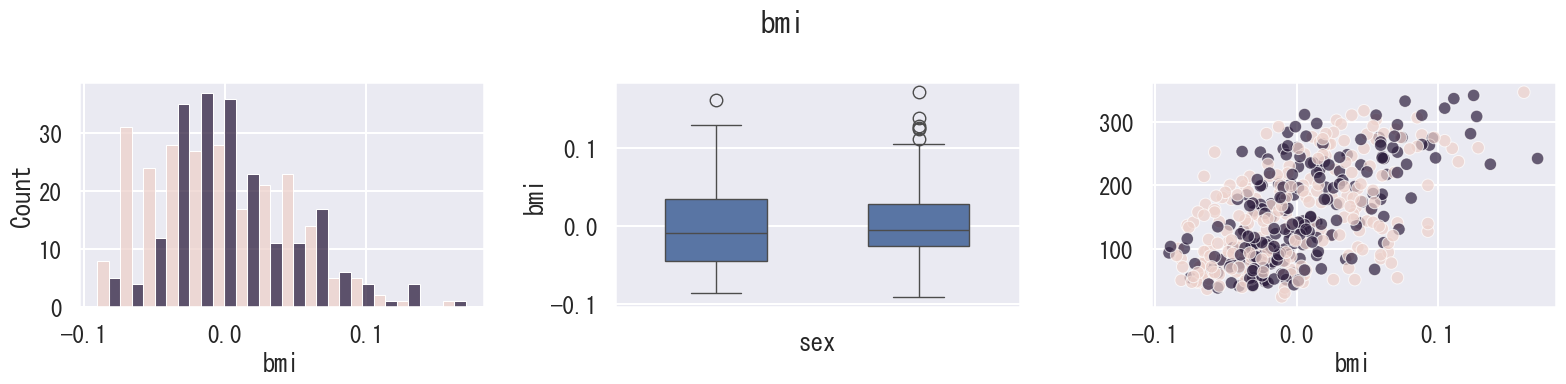

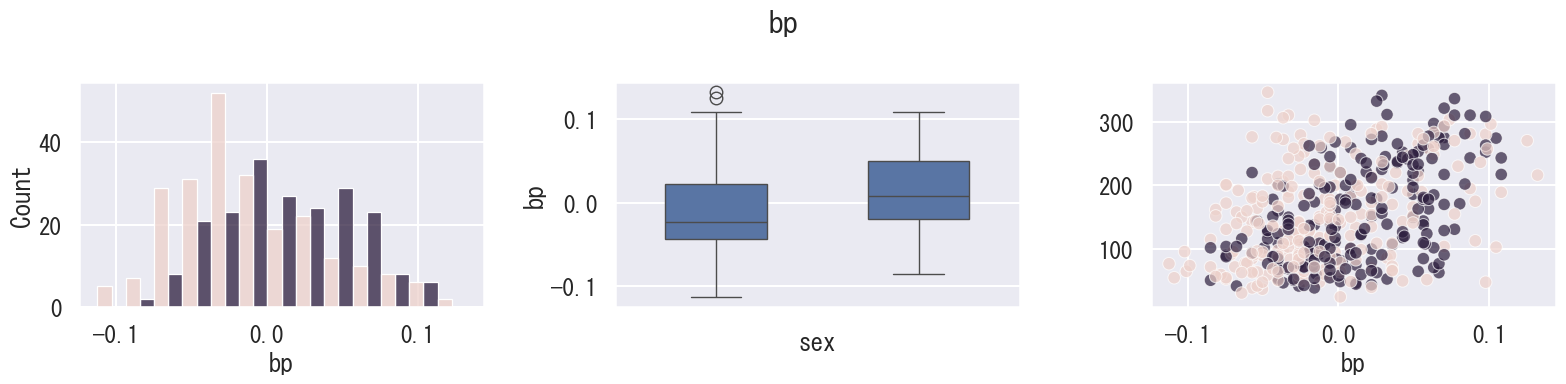

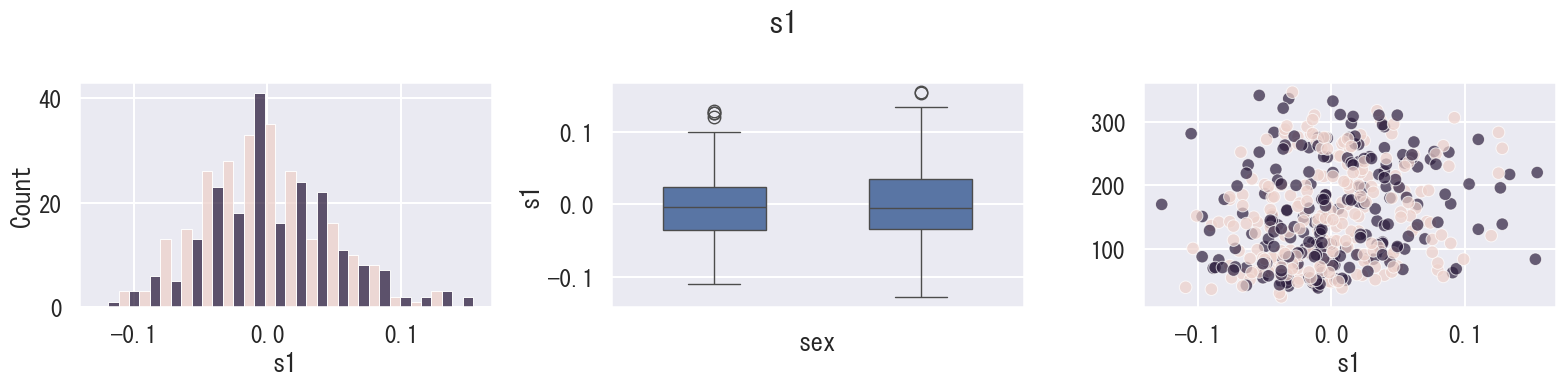

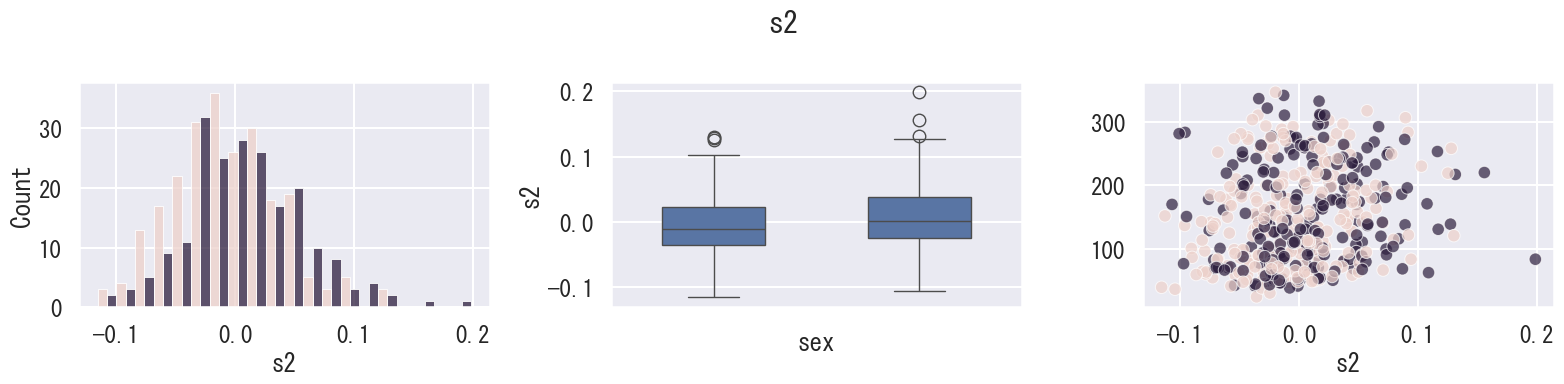

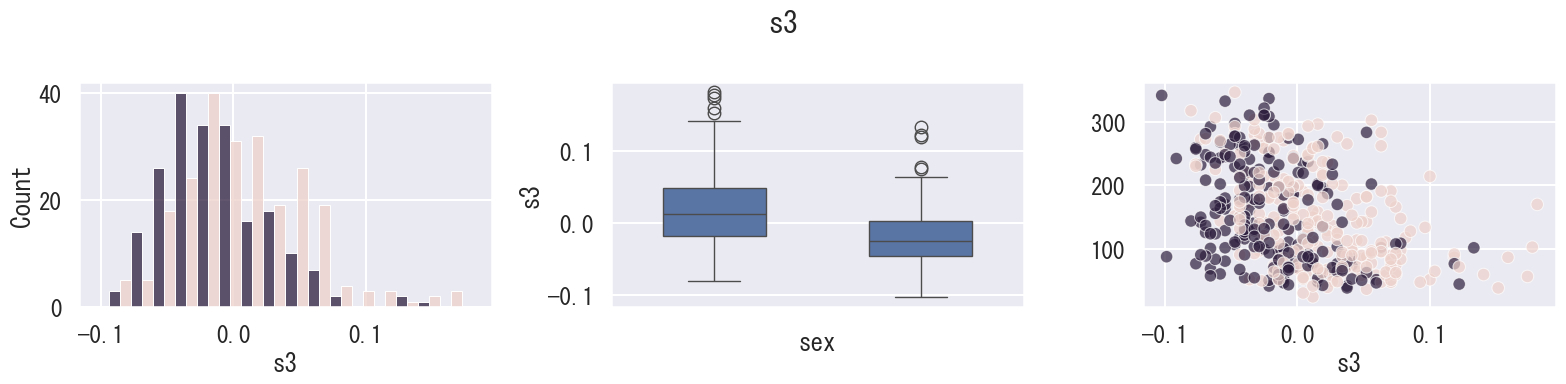

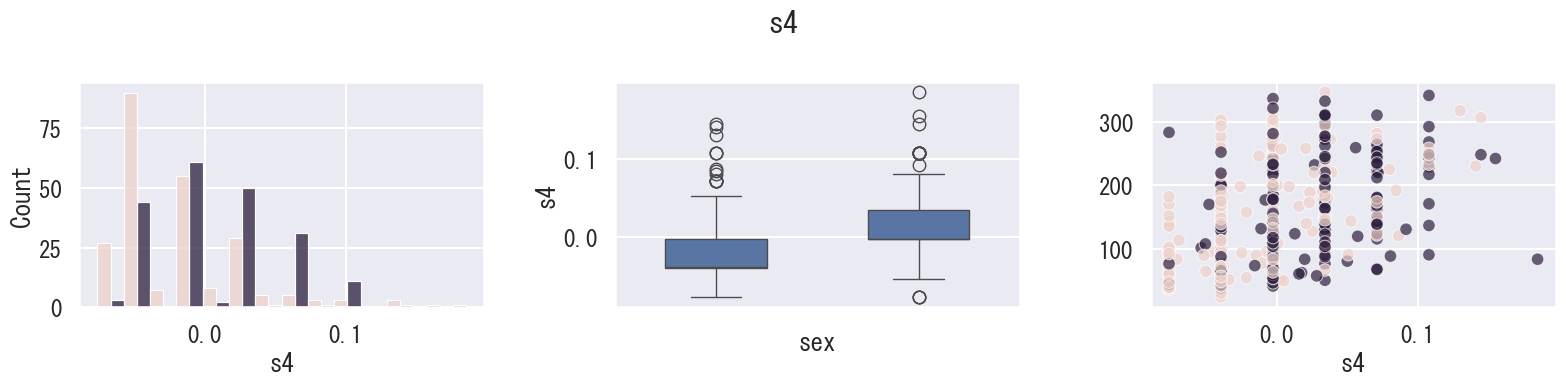

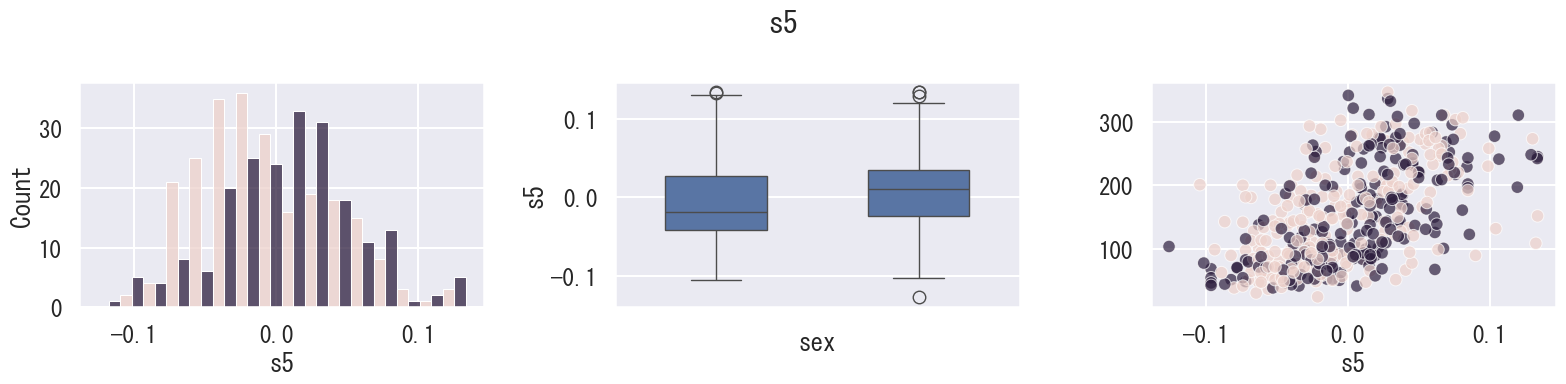

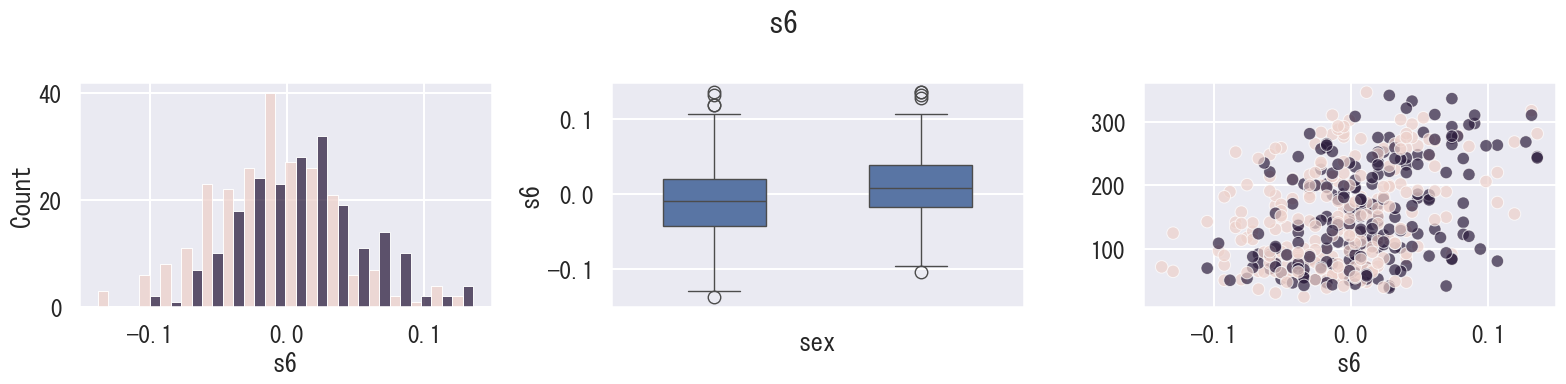

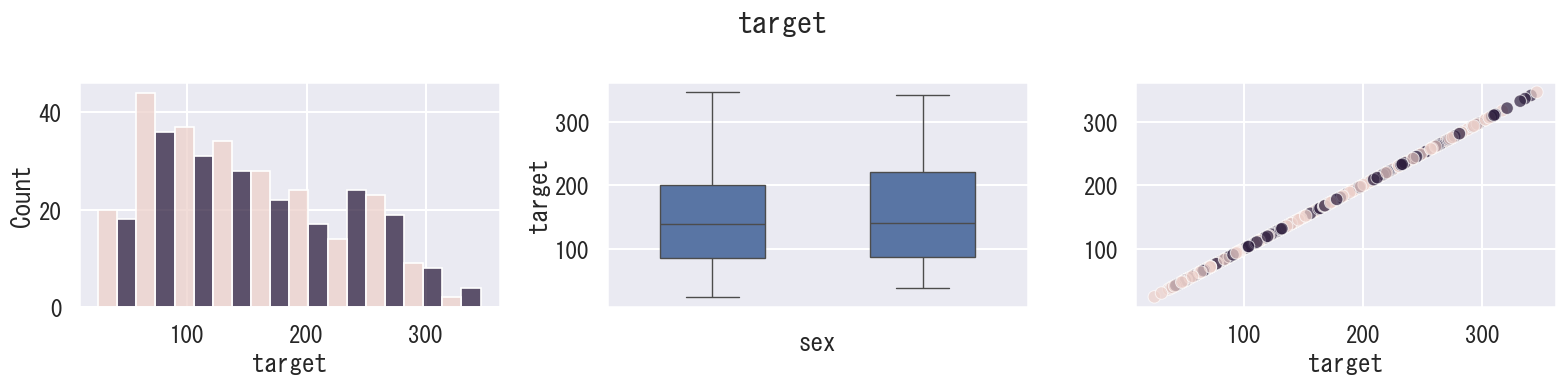

In [28]:
for feature in df.columns:
    plot_data(feature)

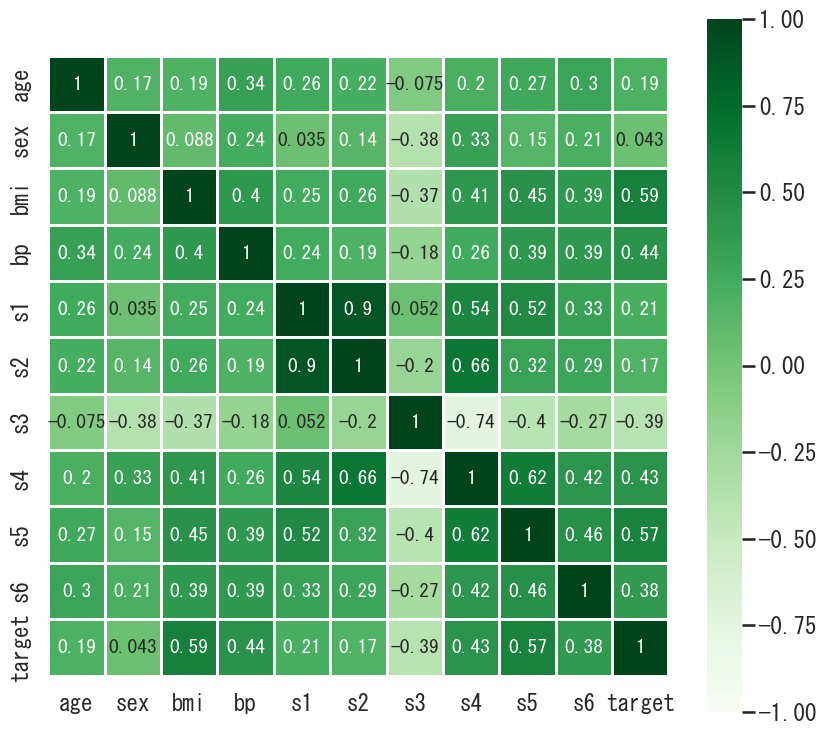

In [30]:
# 特徴量とtargetの相関関係をみていく
plt.figure(figsize=(10, 9))
sns.heatmap(df.corr(), annot=True, annot_kws={'size':14}, cmap='Greens', square=True, linewidth=1, vmin=-1)
plt.show()

In [31]:
df_s0 = df[df['sex'] > 0].drop(columns=['sex'], axis=0)
df_s1 = df[df['sex'] < 0].drop(columns=['sex'], axis=0)

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, shuffle=True)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((309, 10), (133, 10), (309,), (133,))

In [55]:
X0_train, X0_test, y0_train, y0_test = train_test_split(df_s0.iloc[:, :-1], df_s0.iloc[:, -1], test_size=0.3, random_state=17)

In [56]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df_s1.iloc[:, :-1], df_s1.iloc[:, -1], test_size=0.3, random_state=17)

## LinearRegression

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
# モデルインスタンスの作成
lr_model = LinearRegression()

In [40]:
lr_model.fit(X_train, y_train)

LinearRegression()

In [41]:
lr_pred = lr_model.predict(X_test)
lr_pred

array([177.43299832, 235.00503399,  95.42904239, 100.93741348,
       100.65578177,  66.43327209, 113.84109238, 104.45904834,
       150.21311693,  63.9912934 , 230.75607311, 128.83750176,
       104.13547879, 118.66981015, 184.9736666 , 266.66163121,
       177.13376824, 152.08783627, 256.24660976, 178.51041104,
       194.5749372 , 244.87991146, 199.44182722,  95.40129031,
       134.05254017, 192.57373758,  61.06295915, 167.01451475,
        67.62022052, 250.83755407, 136.70445311,  39.61529291,
        75.51135788, 214.16823867, 139.5917269 , 173.96155587,
        54.40729988, 211.30411991,  96.30531847, 202.66420057,
        81.80718121, 110.36606275, 183.80087979, 251.39268338,
       144.94581404,  79.04769012, 229.58095446, 121.5861312 ,
       192.4532645 , 179.63698899, 177.54265819, 158.79064467,
       169.81700533, 137.82772066, 162.05757117, 144.30517687,
        99.81038228, 316.45563871, 139.84968305, 173.16314378,
       163.56606392, 213.23144902,  50.21077197, 144.75

In [42]:
lr_model.coef_

array([  31.55537643, -366.71859113,  490.82617701,  305.01986056,
        -12.9629019 , -211.37683435, -221.56778356,  219.12712275,
        497.68549475,   62.88281073])

In [43]:
lr_model.intercept_

np.float64(151.99058066224876)

In [45]:
# coefficient(係数), intercept(切片)の演算の確認

# ダミーデータ作成
test = np.array([0.01, 0.02, 0.03, 0.04 , 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]).reshape(1, -1)

# 予測値
pred_0 = lr_model.predict(test)

# 演算
pred_1 = lr_model.intercept_
for i in range(10):
    pred_1 += lr_model.coef_[i] * test[0, i]

pred_0, pred_1

(array([211.66698775]), np.float64(211.66698775353223))

### 実測値と予測値の比較

In [48]:
df_result = pd.DataFrame()
df_result['true_value'] = y_test
df_result['prediction'] = lr_pred
df_result['residual'] = y_test - lr_pred
df_result_sorted = df_result.sort_values('true_value', ignore_index=True)

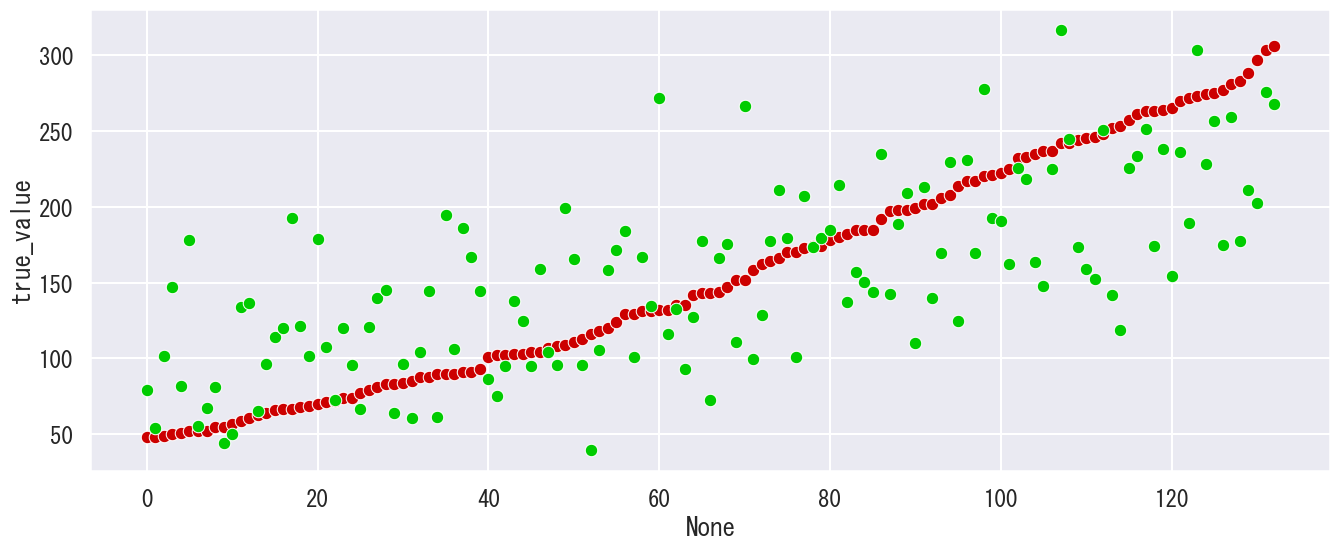

In [49]:
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df_result_sorted, x=df_result.index, y='true_value', color='#c00')
sns.scatterplot(data=df_result_sorted, x=df_result.index, y='prediction', color='#0c0')
plt.show()

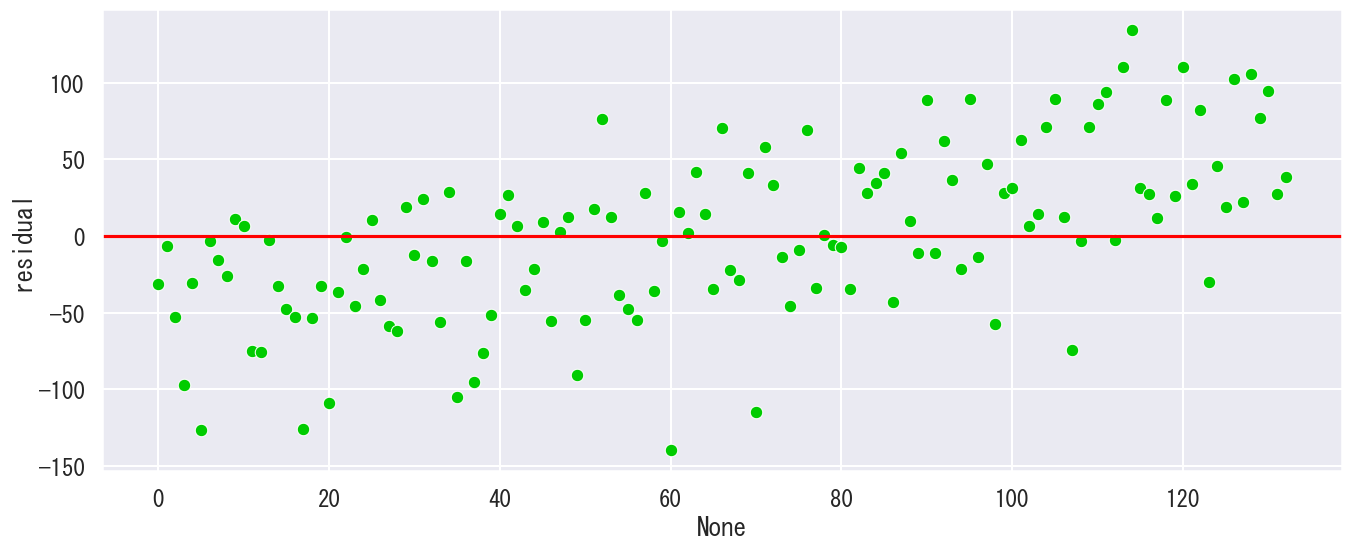

In [51]:
# 残差の可視化
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df_result_sorted, x=df_result_sorted.index, y='residual', color='#0c0')
plt.axhline(0, color='#f00')
plt.show()

In [52]:
lr_model.score(X_test, y_test)

0.4653088132347174

In [53]:
lr_model.score(X_train, y_train)

0.5213195909524871

In [58]:
# 性別ごとのデータで試してみる
lr_model_s0 = LinearRegression()
lr_model_s0.fit(X0_train, y0_train)
lr_model_s0.score(X0_test, y0_test), lr_model_s0.score(X0_train, y0_train)


(0.5472026714756058, 0.5955480185654833)

In [60]:
lr_model_s1 = LinearRegression()
lr_model_s1.fit(X1_train, y1_train)
lr_model_s1.score(X1_test, y1_test), lr_model_s1.score(X1_train, y1_train)

(0.5210267736804209, 0.4558535970823838)

## RandomForestRegressor

In [61]:
from sklearn.ensemble import RandomForestRegressor

ドキュメント:https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [62]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    bootstrap=True,
    random_state=17,
    max_samples=None,
    )

In [63]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=17)

In [67]:
rf_pred = rf_model.predict(X_test)
rf_pred[:5]

array([177.29, 221.03,  95.38, 127.42, 111.14])

In [69]:
rf_model.feature_importances_

array([0.06286879, 0.02094875, 0.23385147, 0.08764819, 0.04107012,
       0.05116433, 0.05610629, 0.02369583, 0.34937982, 0.07326641])

In [70]:
rf_model.score(X_test, y_test)

0.49161172426003963

In [71]:
rf_model.score(X_train, y_train)

0.9198706580063137

過学習(overfitting)が起きていることがわかる

パラメータを変更して再度実行する

In [73]:
rf_model_new = RandomForestRegressor(
    n_estimators=120, # DecisionTreeRegressorの数
    max_depth=4, # 分岐を最大何回まで行うか
    min_samples_split=5, # サンプルが最小いくつまで分岐を行うか
    min_samples_leaf=1, # 末端での最小のサンプル数
    max_features=0.6, # 最大いくつの特徴量を使うか
    bootstrap=True, # 多様性を増やすためのサンプルのランダムな割り当て
    random_state=17,
    max_samples=0.7, # bootstrap=Trueの場合のサンプルの最大数。0-1.0で指定すればよい
    )

In [74]:
rf_model_new.fit(X_train, y_train)
rf_pred_new = rf_model_new.predict(X_test)
rf_pred_new[:5]

array([176.37411581, 219.15230835,  98.60710126, 110.40610849,
       106.5296587 ])

In [75]:
rf_model_new.score(X_test, y_test)

0.5116264791328704

In [76]:
rf_model_new.score(X_train, y_train)

0.6376734717657231

## KNeighborsRegressor

In [85]:
from sklearn.neighbors import KNeighborsRegressor

In [87]:
# インスタンスの作成
kn_model = KNeighborsRegressor(n_neighbors=5, weights='uniform')

In [89]:
kn_model.fit(X_train, y_train)
kn_pred  = kn_model.predict(X_test)
kn_pred[:5]

array([161.4, 186.6, 100.4, 125. , 120.2])

In [90]:
kn_model.score(X_test, y_test)

0.39363769594293097

In [91]:
kn_model.score(X_train, y_train)

0.5679093128613815

パラメータを変更して再度実行

In [92]:
kn_model_new = KNeighborsRegressor(n_neighbors=12, weights='uniform')

In [93]:
kn_model_new.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=12)

In [94]:
kn_model_new.score(X_test, y_test)

0.4797261727192119

In [95]:
kn_model_new.score(X_train, y_train)

0.5215812278605085

## 評価方法
metricsは指標という意味

In [96]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

### accuracy_score
正確度スコアのｋとで、モデルが正しく予測したデータポイントの割合をしめす。分類問題で使用される

$$
\mathrm{Accuracy} = \frac{\text{正解の個数}}{{全データの個数}}
$$

### mean_absolute_error
Mean Absolute Errorは平均絶対誤差のことであり、回帰問題で使用される
$$
\mathrm{MAE} = \frac{1}{n} \sum_{i=1}^{n}|y_i - \hat{y}_i|
$$

ここで、$n$はデータ数で$y_i$は実測値で$\hat{y}_i$は予測値である

### mean_squared_error
Mean Squared Errorは平均二乗誤差のことであり、回帰問題で使用される
$$
\mathrm{MSE} = \frac{1}{n} \sum_{i=1}^{n}\left(y_i - \hat{y}_i\right)^2
$$

### mean_absolute_percentage_error
Mean Absolute Percentage Error(平均絶対パーセンテージ誤差)
$$
\mathrm{MAPE} = \frac{100}{n} \sum_{i=1}^n | \frac{y_i - \hat{y}_i}{y_i} | 
$$

### r2_score
R2 Score(決定係数)は1に近いほどモデルの予測が実測値にちかいことを意味する
$$
R^2 = 1 - \frac{\sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2}{\sum_{i=1}^n \left(y_i - \bar{y}_i\right)^2}
$$

ここで、$\bar{y}$は実測値の平均である

In [102]:
def eval_models(models, X_train, y_train, X_test, y_test):
    for model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        score = np.round(model.score(X_test, y_test), 4)
        mae = np.round(mean_absolute_error(y_test, pred), 4)
        mse = np.round(mean_squared_error(y_test, pred), 4)
        mape = np.round(mean_absolute_percentage_error(y_test, pred), 4)
        r2 = np.round(r2_score(y_test, pred), 4)
        print(f'{model}')
        print(f'score: {score}, mae: {mae}, mse: {mse}, mape: {mape}, r2: {r2}')
        print('===================================================================')

In [103]:
models = {lr_model, rf_model_new, kn_model_new}
eval_models(models, X_train, y_train, X_test, y_test)

RandomForestRegressor(max_depth=4, max_features=0.6, max_samples=0.7,
                      min_samples_split=5, n_estimators=120, random_state=17)
score: 0.5116, mae: 43.3375, mse: 2779.0163, mape: 0.3645, r2: 0.5116
KNeighborsRegressor(n_neighbors=12)
score: 0.4797, mae: 43.7563, mse: 2960.5403, mape: 0.3623, r2: 0.4797
LinearRegression()
score: 0.4653, mae: 43.8217, mse: 3042.5801, mape: 0.3629, r2: 0.4653


## クロスバリデーションとグリッドサーチ